<a href="https://colab.research.google.com/github/SahajTC/Augmented-Financial-Intelligence/blob/main/XGBoost_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from prophet.diagnostics import cross_validation, performance_metrics
import seaborn as sns 
import matplotlib.pyplot as plt
     

In [3]:
import yfinance as yf
btc=yf.download(tickers='BTC-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#bitcoin
eth=yf.download(tickers='ETH-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#etherum
bnb=yf.download(tickers='BNB-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#binance

doge=yf.download(tickers='DOGE-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#dogecoin
dot=yf.download(tickers='DOT-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#polkadot
atom=yf.download(tickers='ATOM-USD', start='2020-01-01', end='2022-11-30', interval = '1d')#cosmos

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def mod_train(df):
  df.reset_index(inplace=True)
  df['Date'] = pd.to_datetime(df['Date'])
  closedf = df[['Date','Close']]
  closedf = closedf[closedf['Date'] > '2020-01-01']
  close_stock = closedf.copy()
  del closedf['Date']
  scaler=MinMaxScaler(feature_range=(0,1))
  closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
  training_size=int(len(closedf)*0.8)
  test_size=len(closedf)-training_size
  train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]

  fig, ax = plt.subplots(figsize=(15, 6))
  sns.lineplot(x = close_stock['Date'][:510], y = close_stock['Close'][:510], color = 'black')
  sns.lineplot(x = close_stock['Date'][510:], y = close_stock['Close'][510:], color = 'red')

  ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
  ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
  ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
  plt.tick_params(axis='y', which='major', labelsize=16)
  plt.tick_params(axis='x', which='major', labelsize=16)
  plt.legend(loc='upper right' ,labels = ('train', 'test'))
  def create_dataset(dataset, time_step=1):
      dataX, dataY = [], []
      for i in range(len(dataset)-time_step-1):
          a = dataset[i:(i+time_step), 0]   ###i=0,1,2,3.......
          dataX.append(a)
          dataY.append(dataset[i + time_step, 0])
      return np.array(dataX), np.array(dataY)
  time_step = 15
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)
  ###
  from xgboost import XGBRegressor
  from sklearn.model_selection import GridSearchCV

  param_grid = {
      'n_estimators': [100, 500, 1000, 2500, 5000],
  }
  search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5, verbose=1)
  search.fit(X_train, y_train)

  my_model = XGBRegressor(**search.best_params_)
  my_model.fit(X_train, y_train, verbose=False)
  predictions = my_model.predict(X_test)
  ###
  def mape(actual, pred): 
      actual, pred = np.array(actual), np.array(pred)
      return np.mean(np.abs((actual - pred) / actual)) * 100
  mape= mape(y_test,predictions)
  print('MAPE = '+str(mape))

In [5]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:04] WARNING: /workspace/src/objective/regres

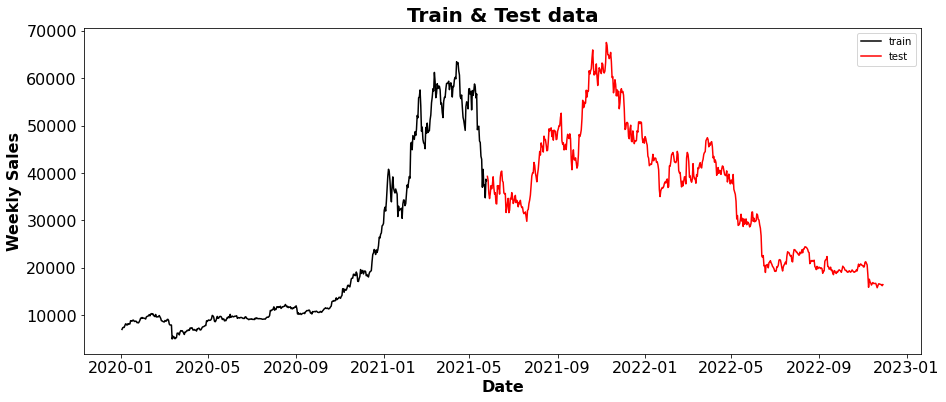

In [6]:
mod_train(btc)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:41] WARNING: /workspace/src/objective/regres

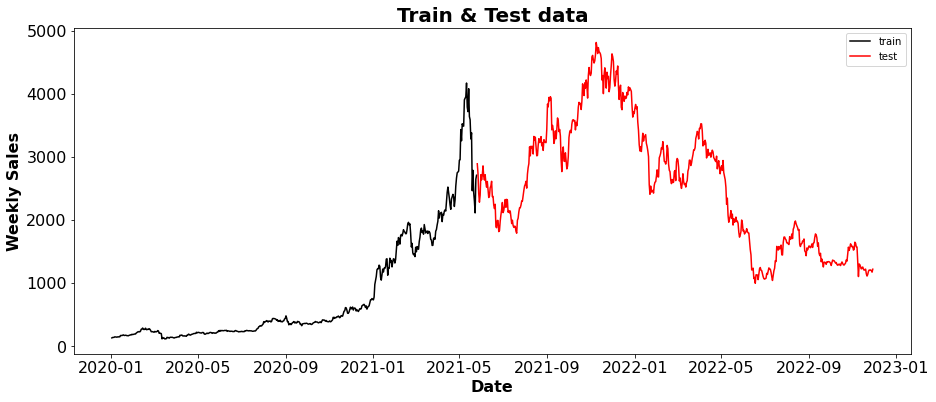

In [7]:
mod_train(eth)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:18] WARNING: /workspace/src/objective/regres

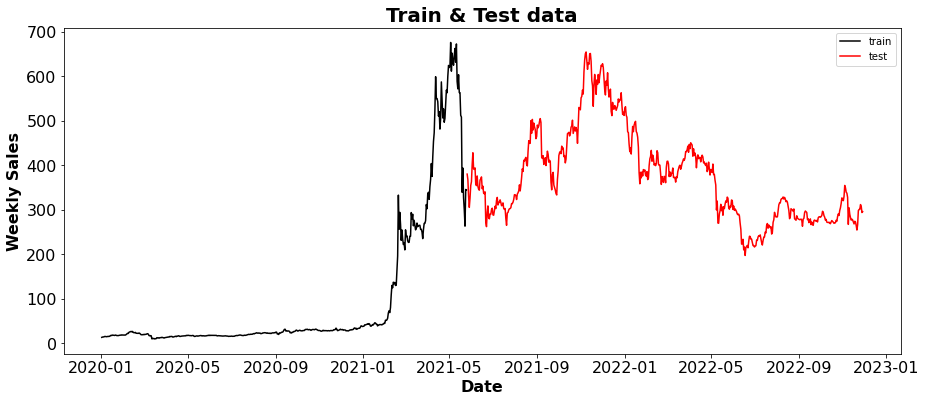

In [8]:
mod_train(bnb)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:46] WARNING: /workspace/src/objective/regres

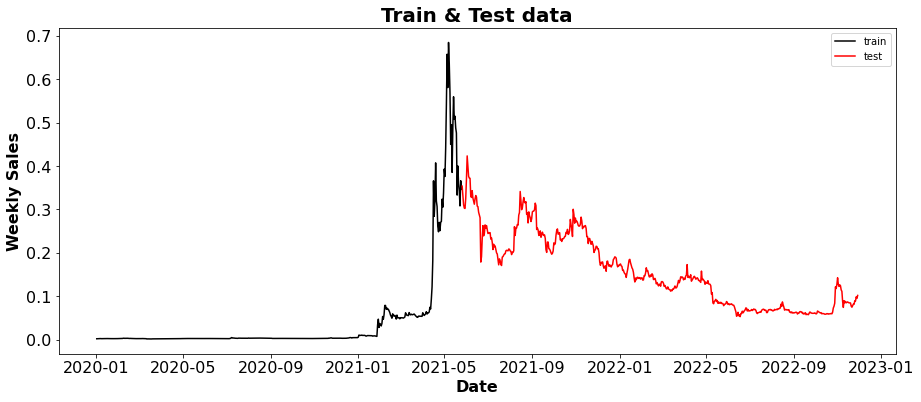

In [9]:
mod_train(doge)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:11] WARNING: /workspace/src/objective/regres

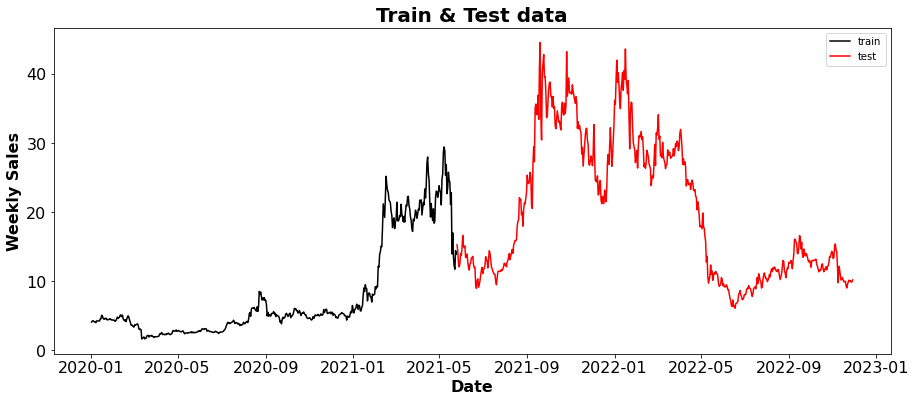

In [10]:
mod_train(atom)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[05:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:36] WARNING: /workspace/src/objective/regres

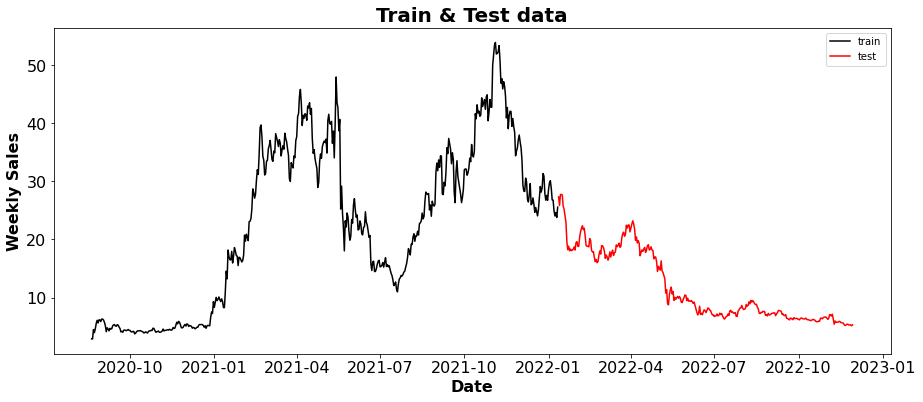

In [11]:
mod_train(dot)